In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa

In [2]:
class ChirpStartEndPointExtractor:
    
    def __init__(self,path_to_audio, spacing, padding, amplitude, start):
        
        self.path_to_audio = path_to_audio
        self.spacing = spacing
        self.padding = padding
        self.amplitude = amplitude
        self.start = start
        
    
    def read_normalize_cricket_signal(self,audio_file):
        
        """INPUT: raw audio file
           DO:    read the audio file using scipy module, remove samples from the first 10 secs
                  normalized the signal between 1 and -1
           OUTPUT: normalized signal
        """
        
        array_signal, sr = librosa.load (self.path_to_audio+audio_file, sr = None, offset = None)
        signal = array_signal[sr*self.start:]
     
        return signal/np.abs(signal).max()  
        
        
    
    def detect_cricket_call(self, normalized_signal, spacing, padding, amplitude):
    
        """INPUTS: signal -- call in which to detect cricket chirp calls
                   spacing -- threshold used to separate consecutive chirps
                   padding -- padding added at the beginning and end chirp calls to avoid cropping extremity points
                   0.1 is the amplitude beyond which we assume a call

           DO   : Extract start call chirp indexes: take the difference btwn consecutive signals and call occurs where
                  the difference > spacing. Assuming absence of a call (spacing*5) before cricket starts calling
                  makes the # of signals = # of silent events. The index of a silent event in the list of silent evts
                  is the same as the one of the signal call starting a chirp in the list of call signals i.e,
                  ---|-|-|---|-|-|
                  Similary, extracting end call chirp indexes is achieved by repeating the above steps on the inverted
                  signal i.e. signal[::-1]. Indexes in non-inverted signals are obtained by taking len(signal) - indexes
                  in the inverted signal.

          OUTPUT: start- and end call indexes.
        """
        # Extract start chirp call indexes

        where_call_occurrence = np.where(np.abs(normalized_signal) > amplitude)[0]
        where_call_absence = where_call_occurrence[1:where_call_occurrence.shape[0]]-\
        where_call_occurrence[0:where_call_occurrence.shape[0]-1]
        difference = np.hstack([spacing*5, where_call_absence])
        start_call = where_call_occurrence[difference > spacing]

        # Extract end chirp call indexes

        inverted_normalized_signal = normalized_signal[::-1]
        where_call_occurrence_inv = np.where(np.abs(inverted_normalized_signal) > amplitude)[0]
        where_call_absence_inv = where_call_occurrence_inv[1:where_call_occurrence_inv.shape[0]]-\
        where_call_occurrence_inv[0:where_call_occurrence_inv.shape[0]-1]
        difference_inv = np.hstack([spacing*5, where_call_absence_inv])
        end_call = inverted_normalized_signal.shape[0] - where_call_occurrence_inv[difference_inv > spacing]

        # padding chirps to avoid cropping start and end chirp call points

        start_call_padded = np.maximum(0,start_call - padding)
        end_call_padded = np.minimum(end_call[::-1] + padding,normalized_signal.shape[0])


        return  start_call_padded, end_call_padded


    def check_click_detector(self, xx, click_start, click_end):
        
        """plot a portion of the signal, the chirp call starts with a vertical red line
            and ends with a vertical green line
        """
        plt.figure(figsize = (25,5))
        plt.plot(xx)
        plt.vlines(x= click_start,color = "r",ymin = xx.min(), ymax = xx.max())
        plt.vlines(x= click_end,color = "g",ymin = xx.min(), ymax = xx.max())
        plt.show()
    
  
    
    def ID_night_call(self,audiofile):
        
        """INPUT: audio file named XXX_nN_P.WAV or XXX_P.WAV with XXX ID, nN Nth call in night P
           DO   : Extract ID, night, call, and name the file as ID-night-call
           OUTPUT: namedfile, ID, night, call
        """
        audio = audiofile[:-4]
        if len(audio) == 8:
            ID = audio[:3]
            night = audio[-1]
            call = audio[-3]
        elif len(audio) == 5:
            ID = audio[:3]
            night = audio[-1]
            call = str(1)
        else:
            assert len(audio) == 8 or 3

        audio_file = ID+night+call

        return audio_file, ID, int(night), int(call)
    
    def Data_Frame(self):
        return pd.DataFrame(columns = ["Chirp","ID","Start","End","Night","Call","Syllables"]).set_index("Chirp")
    
    
    def Execution(self, space, pad, amp):
        
        """INPUTS: audio file -- space, pad, and amp are spacing, padding, and amplitude parameters
                   used when extracting chirp syllables while SPACING, PADDING, and AMPLITUDE
                   are used when extracting chirps.
           DO    : Find starting and end chirp call indexes and count chirp syllables
           
           OUTPUT: a data frame containing chirps and their characteristics
        """
        all_dfs = []
        for audiofile in os.listdir(self.path_to_audio):
            
            normalized_signal = self.read_normalize_cricket_signal(audiofile)
            start_, end_ = self.detect_cricket_call(normalized_signal, self.spacing, self.padding, self.amplitude)
            # Ignore the first chirp
            start, end = start_[1:],end_[1:]
            #start, end = start_, end_
            
            audio_file, ID, night, call = self.ID_night_call(audiofile)
            
            # Finding number of syllables in extracted chirps/calls
            # use the same function as chirp but with different parameters
            
            chirp2characteristics = {}
            
            for idx in range(start.shape[0]):
                st_syl, end_syl = self.detect_cricket_call(normalized_signal[start[idx]:end[idx]], space, pad, amp)
                nb_syllables = end_syl.shape[0]
                chirp = audio_file+'_'+str(idx)
                chirp2characteristics[chirp] = (ID,start[idx],end[idx],night,call,nb_syllables)
                dataframe = self.Data_Frame()
                
                for chirp,characteristics in chirp2characteristics.items():
                    dataframe.loc[chirp] = chirp2characteristics[chirp]
            dataframe["Audio"] = [audiofile]*dataframe.shape[0]
            all_dfs.append(dataframe)
        df = pd.concat(all_dfs)
        df.to_csv("chirp_data.csv", index = True)

        return df


In [3]:
pathAudioFiles = "../segment_index_extraction/audio_files/"

In [4]:
chirp = ChirpStartEndPointExtractor(pathAudioFiles, 2000, 200,0.1,10 )

In [5]:
df = chirp.Execution(235, 200,0.1)

In [6]:
df

,ID,Start,End,Night,Call,Syllables,Audio
Chirp,,,,,,,
LPL11_0,LPL,5674,11886,1,1,5,LPL_1.WAV
LPL11_1,LPL,16283,18003,1,1,2,LPL_1.WAV
LPL11_2,LPL,20169,26467,1,1,5,LPL_1.WAV
LPL11_3,LPL,29708,31360,1,1,2,LPL_1.WAV
LPL11_4,LPL,33187,37640,1,1,4,LPL_1.WAV
...,...,...,...,...,...,...,...
RBB13_257,RBB,3149422,3152645,1,3,3,RBB_n3_1.WAV
RBB13_258,RBB,3156443,3164070,1,3,5,RBB_n3_1.WAV
RBB13_259,RBB,3172907,3180379,1,3,5,RBB_n3_1.WAV


In [7]:
signal1 = librosa.load(pathAudioFiles + "BKB_n2_1.WAV", sr = None, offset=10)[0]

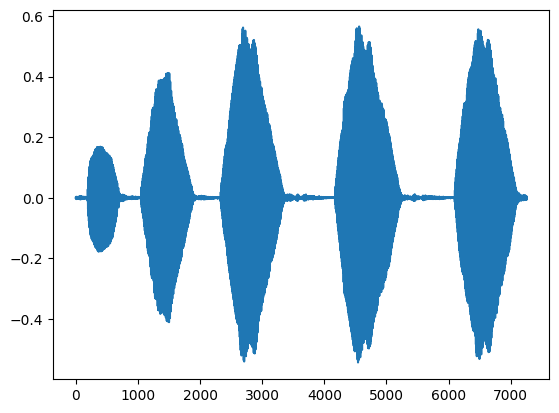

In [8]:
plt.plot(signal1[18826:26083])

In [9]:
st = 444200
end = 494200

In [10]:
# Detecting chirps in the portion of the signal1 starting from st up to end
clickstart, clickend = chirp.detect_cricket_call(signal1[st:end], 2000, 200, 0.1)

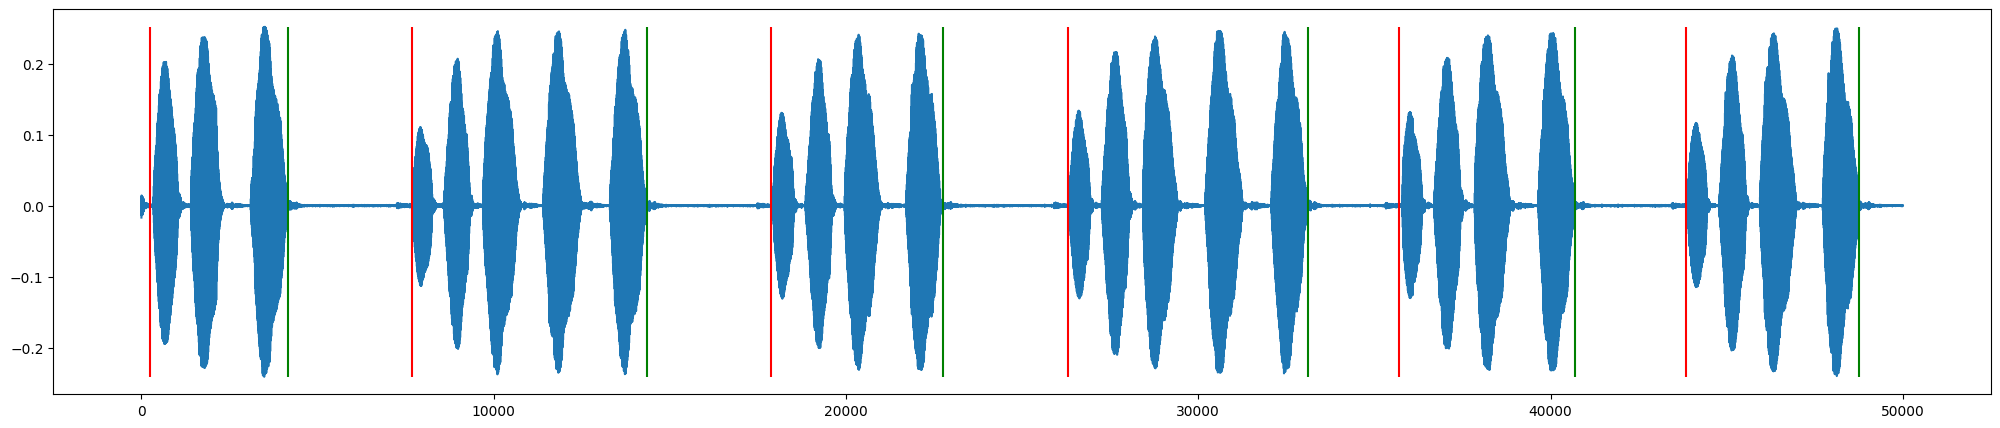

In [11]:
chirp.check_click_detector(signal1[st:end],clickstart, clickend)

In [12]:
# extract the 2nd chirp in the plot above, which is a 5-syllable chirp
i = 1
mysig = signal1[st:end][clickstart[i]:clickend[i]]

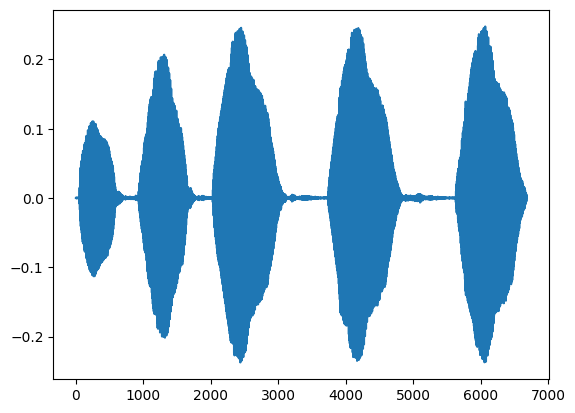

In [13]:
plt.plot(mysig)

In [14]:
# Let us detech syllables in 5-syllable chirp above
sts, ends = chirp.detect_cricket_call(mysig, 235, 200,0.1)

In [15]:
def _check_click_detector(xx, click_start, click_end):
    plt.figure(figsize = (6,8))
    plt.plot(xx)
    plt.vlines(x= click_start,color="r",ymin = xx.min(), ymax = xx.max())
    plt.vlines(x= click_end,color="g",ymin = xx.min(), ymax = xx.max())
    plt.savefig("syllable.pdf")
    plt.show()

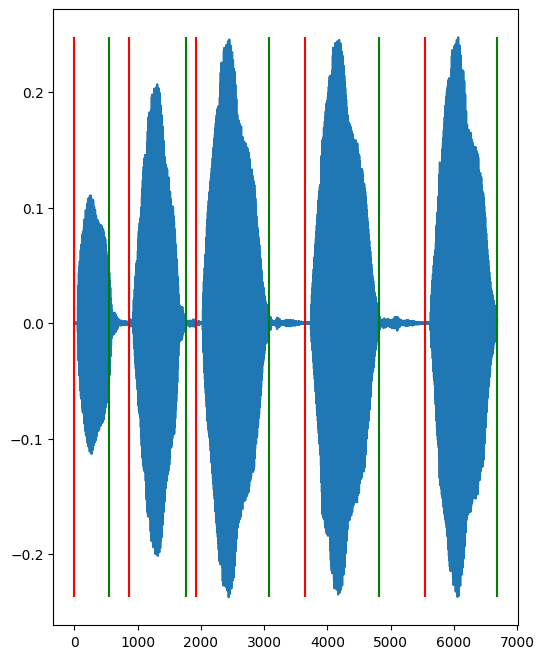

In [16]:
_check_click_detector(mysig, sts, ends)